In [83]:
%cd RowanDLclassNEA

[Errno 2] No such file or directory: 'RowanDLclassNEA'
/home/armani/DL_class/RowanDLclassNEA


In [84]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly


#### We need to write a transform to make it compatible with AlexNet (size 224x224x3, and type tensor)

In [85]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root='NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

In [86]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)

print(len(trainloader))
# out: 2500
print(len(valloader))
# out: 625

75
38


 ### We are going to illustrate transfer learning now
Transfer starts with a pretrained model from the torchvision library. The pretrained model will be resnet18. This model is trained on ImageNet 1K (this is the default for resnet18: DEFAULT = IMAGENET1K_V1)
The fact that ImageNet consists of RGB images of size 224 x 224 demanded our data resizing in the transform

In [87]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

model= models.resnet18()
summary(model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

layers = list(model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
vec_model = nn.Sequential(*layers)
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)


# Modified Cell
Armani Rodriguez

In [88]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
vec_model = nn.Sequential(*layers)
layers.append(nn.Linear(512,6))
vec_orig_model = nn.Sequential(*layers)

Epoch: 0 Train Loss: 0.023874908424913882 Val Loss: 0.006150644627938929
Epoch: 1 Train Loss: 0.024695446280141673 Val Loss: 0.005073960711199202
Epoch: 2 Train Loss: 0.041200126577168705 Val Loss: 0.009164252735086177
Epoch: 3 Train Loss: 0.041100902644296486 Val Loss: 0.007437657227886743
Epoch: 4 Train Loss: 0.02447776704095304 Val Loss: 0.006860011778036623
Epoch: 5 Train Loss: 0.03364068779473504 Val Loss: 0.006281515914260557
Epoch: 6 Train Loss: 0.040733717304343976 Val Loss: 0.007795919076000389
Epoch: 7 Train Loss: 0.02399870836486419 Val Loss: 0.005431752406844967
Epoch: 8 Train Loss: 0.037834225818514824 Val Loss: 0.00693018251025167
Epoch: 9 Train Loss: 0.026603021696209907 Val Loss: 0.00581169825071763
Epoch: 10 Train Loss: 0.023085418309395513 Val Loss: 0.005779461334704568
Epoch: 11 Train Loss: 0.023032317083949844 Val Loss: 0.004509633100640617
Epoch: 12 Train Loss: 0.02548178408605357 Val Loss: 0.0051532223036414694
Epoch: 13 Train Loss: 0.027223096409191686 Val Loss: 

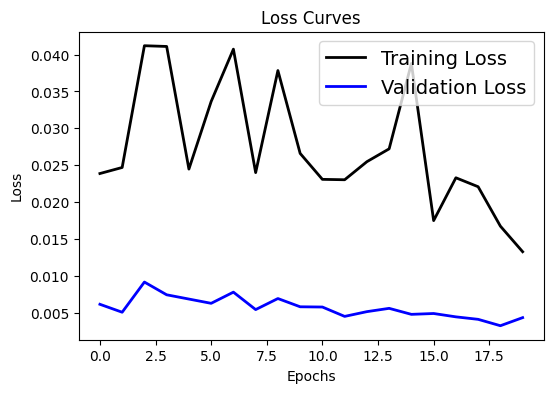

In [93]:
from torch import optim
from torch import nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

test_dataset = DatasetFolder(root='NEUdata_split/Test/', loader = load_image, extensions = ('.bmp',), transform = transform)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16
)
n_correct = 0
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    n_correct += torch.sum(preds == labels.data)
print(f'{100* n_correct/len(test_dataset) :.3f}% accuracy({n_correct}/{len(test_dataset)} Correct)')



# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
plt.show()

Epoch: 0 Train Loss: 0.2987047319610914 Val Loss: 0.005959536757712301
Epoch: 1 Train Loss: 0.043341702963225544 Val Loss: 0.00466791349294669
Epoch: 2 Train Loss: 0.024134746599787225 Val Loss: 0.003175566483773046
Epoch: 3 Train Loss: 0.018057448785596838 Val Loss: 0.0017314495752017184
Epoch: 4 Train Loss: 0.01728041348668436 Val Loss: 0.004590094589251461
Epoch: 5 Train Loss: 0.020483452019204075 Val Loss: 0.018112956018548607
Epoch: 6 Train Loss: 0.020394716475857423 Val Loss: 0.00735314726290725
Epoch: 7 Train Loss: 0.012553733356374627 Val Loss: 0.0020753031194066067
Epoch: 8 Train Loss: 0.012985328839858994 Val Loss: 0.0017294977677872673
Epoch: 9 Train Loss: 0.005981070888616766 Val Loss: 0.006011831674282132
Epoch: 10 Train Loss: 0.004566836702967218 Val Loss: 0.0012730842340955093
Epoch: 11 Train Loss: 0.013198615793759624 Val Loss: 0.0007804407477555
Epoch: 12 Train Loss: 0.010063370425292912 Val Loss: 0.000626932454954505
Epoch: 13 Train Loss: 0.005082430182568108 Val Loss

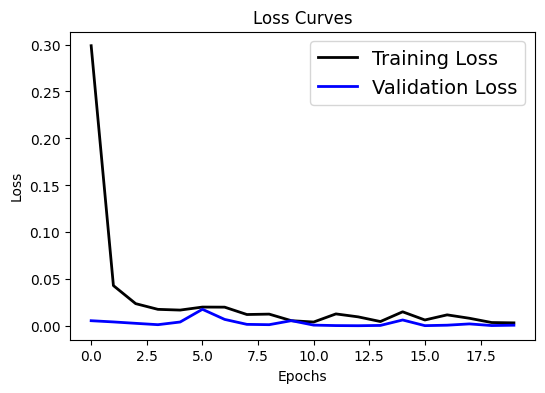

In [90]:
from torch import optim
from torch import nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_orig_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

n_correct = 0
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    n_correct += torch.sum(preds == labels.data)
print(f'{100* n_correct/len(test_dataset) :.3f}% accuracy({n_correct}/{len(test_dataset)} Correct)')
    

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
plt.show()

Epoch: 0 Train Loss: 0.0032487583232189837 Val Loss: 0.0005115322652081408
Epoch: 1 Train Loss: 0.0025317435591326407 Val Loss: 0.00045833890018050287
Epoch: 2 Train Loss: 0.0038733867103777206 Val Loss: 0.00063204220580366
Epoch: 3 Train Loss: 0.013819548577109042 Val Loss: 0.0007904441091389009
Epoch: 4 Train Loss: 0.006281220640618509 Val Loss: 0.0005122843019642843
Epoch: 5 Train Loss: 0.004210746643172267 Val Loss: 0.0005527914778021545
Epoch: 6 Train Loss: 0.002839869253512006 Val Loss: 0.0003904434545945964
Epoch: 7 Train Loss: 0.0022018293818109667 Val Loss: 0.0005839721127478313
Epoch: 8 Train Loss: 0.0022613318227619555 Val Loss: 0.00041022348841579515
Epoch: 9 Train Loss: 0.0044019611791979215 Val Loss: 0.0006547723902066968
Epoch: 10 Train Loss: 0.004717160791915376 Val Loss: 0.0005390410013588783
Epoch: 11 Train Loss: 0.008699390416538033 Val Loss: 0.00046133363732798517
Epoch: 12 Train Loss: 0.003531822550188129 Val Loss: 0.0003279643906831839
Epoch: 13 Train Loss: 0.0032

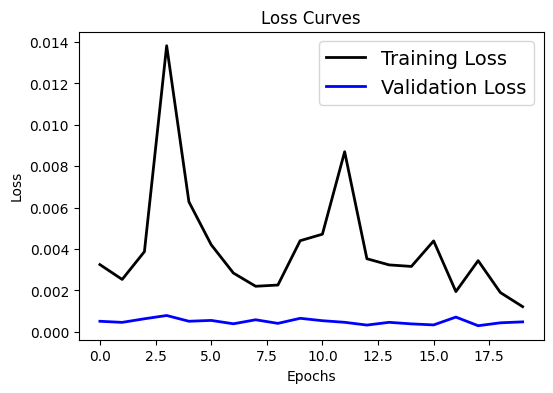

In [91]:
from torch import optim
from torch import nn
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_orig_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)

N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

n_correct = 0
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    n_correct += torch.sum(preds == labels.data)
print(f'{100* n_correct/len(test_dataset) :.3f}% accuracy({n_correct}/{len(test_dataset)} Correct)')
# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
plt.show()